
# Testing a Potential Moderator

In [1]:

import pickle
import pandas as pd

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

# Change this to your data and saves folders
data_folder = r'../../data/'
saves_folder = r'../../saves/'

def load_object(obj_name, download_url=None):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    if not os.path.isfile(pickle_path):
        csv_path = saves_folder + 'csv/' + obj_name + '.csv'
        if not os.path.isfile(csv_path):
            object = pd.read_csv(download_url, low_memory=False,
                                 encoding=encoding)
        else:
            object = pd.read_csv(csv_path, low_memory=False,
                                 encoding=encoding)
        try:
            if isinstance(object, pd.DataFrame):
                object.to_pickle(pickle_path)
            else:
                with open(pickle_path, 'wb') as handle:
                    pickle.dump(object, handle, pickle.HIGHEST_PROTOCOL)
        except:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(object, handle, pickle.HIGHEST_PROTOCOL)
    else:
        try:
            object = pd.read_pickle(pickle_path)
        except:
            with open(pickle_path, 'rb') as handle:
                object = pickle.load(handle)
    
    return(object)

# Classes, functions, and methods cannot be pickled
def store_objects(**kwargs):
    for obj_name in kwargs:
        if hasattr(kwargs[obj_name], '__call__'):
            raise RuntimeError('Functions cannot be pickled.')
        obj_path = saves_folder + 'pickle/' + str(obj_name)
        pickle_path = obj_path + '.pickle'
        if isinstance(kwargs[obj_name], pd.DataFrame):
            kwargs[obj_name].to_pickle(pickle_path)
        else:
            with open(pickle_path, 'wb') as handle:
                pickle.dump(kwargs[obj_name], handle, pickle.HIGHEST_PROTOCOL)

<module 'platform' from 'C:\\Users\\Dave\\Anaconda3\\lib\\platform.py'>


In [2]:

from sklearn.decomposition import PCA
import os

download_url = 'https://raw.githubusercontent.com/jdantonio/ratistics/master/examples/gapminder.csv'
gapminder_df = load_object('gapminder_df', download_url=download_url)
gapminder_df.columns = ['country_name', 'income_per_person',
                        'alcohol_consumption', 'armed_forces_rate',
                        'breast_cancer_per_100th', 'co2_emissions',
                        'female_employment_rate', 'hiv_rate',
                        'internet_use_rate', 'life_expectancy',
                        'oil_per_person', 'polity_score',
                        'residential_electricity_per_person',
                        'suicide_per_100th', 'employment_rate',
                        'urban_rate']
number_column_list = list(set(gapminder_df.columns) - set(['country_name']))
elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

In [3]:

obj_path = saves_folder + 'pickle/formal_name_dict.pickle'
if not os.path.isfile(obj_path):
    formal_name_dict = {}
    formal_name_dict['alcohol_consumption'] = '2008 alcohol consumption per adult (age 15+) in litres'
    formal_name_dict['armed_forces_rate'] = 'Armed forces personnel as a % of total labor force'
    formal_name_dict['breast_cancer_per_100th'] = '2002 breast cancer new cases per hundred thousand females'
    formal_name_dict['co2_emissions'] = '2006 cumulative CO2 emission in metric tons'
    formal_name_dict['employment_rate'] = '2007 total employees age 15+ as a % of population'
    formal_name_dict['female_employment_rate'] = '2007 female employees age 15+ as a % of population'
    formal_name_dict['hiv_rate'] = '2009 estimated HIV Prevalence % for Ages 15-49'
    formal_name_dict['income_per_person'] = '2010 Gross Domestic Product per capita in constant 2000 USD'
    formal_name_dict['internet_use_rate'] = '2010 Internet users per 100 people'
    formal_name_dict['life_expectancy'] = '2011 life expectancy at birth in years'
    formal_name_dict['oil_per_person'] = '2010 oil Consumption per capita in tonnes per year and person'
    formal_name_dict['polity_score'] = '2009 Democracy score as measured by Polity'
    formal_name_dict['residential_electricity_per_person'] = '2008 residential electricity consumption per person in kWh'
    formal_name_dict['suicide_per_100th'] = '2005 Suicide age adjusted per hundred thousand'
    formal_name_dict['urban_rate'] = '2008 urban population as a % of total'
    store_objects(formal_name_dict=formal_name_dict)
else:
    formal_name_dict = load_object('formal_name_dict')

In [4]:

obj_path = saves_folder + 'pickle/informal_name_dict.pickle'
if not os.path.isfile(obj_path):
    informal_name_dict = {}
    informal_name_dict['alcohol_consumption'] = 'alcohol consumption'
    informal_name_dict['armed_forces_rate'] = 'armed forces rate'
    informal_name_dict['breast_cancer_per_100th'] = 'breast cancer'
    informal_name_dict['co2_emissions'] = 'CO2 emissions'
    informal_name_dict['employment_rate'] = 'employment rate'
    informal_name_dict['female_employment_rate'] = 'female employment rate'
    informal_name_dict['hiv_rate'] = 'HIV rate'
    informal_name_dict['income_per_person'] = 'income per person'
    informal_name_dict['internet_use_rate'] = 'internet use rate'
    informal_name_dict['life_expectancy'] = 'life expectancy'
    informal_name_dict['oil_per_person'] = 'oil per person'
    informal_name_dict['polity_score'] = 'polity score'
    informal_name_dict['residential_electricity_per_person'] = 'residential electricity'
    informal_name_dict['suicide_per_100th'] = 'suicide rate'
    informal_name_dict['urban_rate'] = 'urban rate'
    store_objects(informal_name_dict=informal_name_dict)
else:
    informal_name_dict = load_object('informal_name_dict')

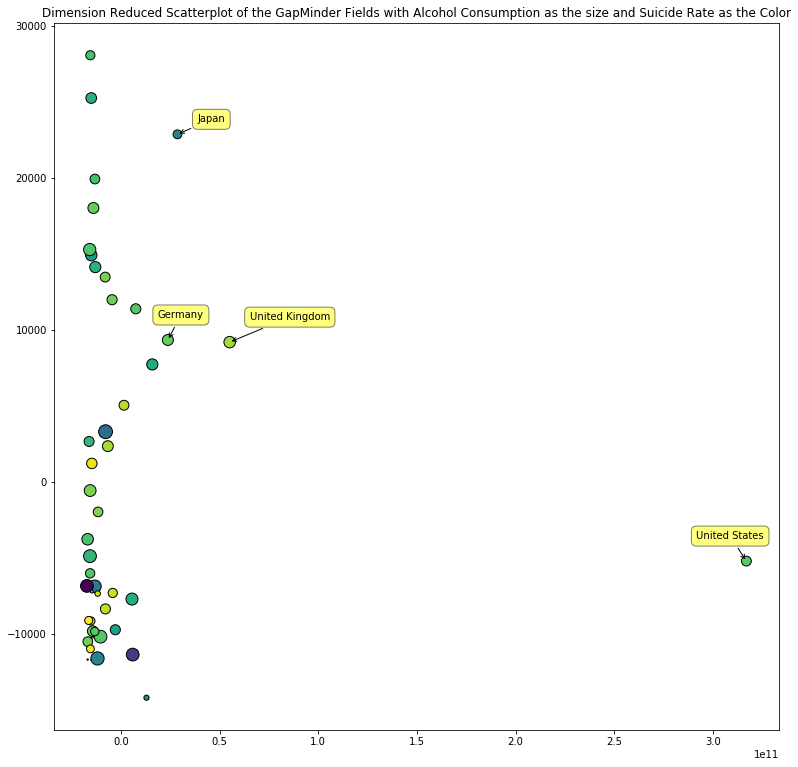

In [5]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             s=elite_df['alcohol_consumption']*10,
                             c=elite_df['suicide_per_100th'],
                             edgecolors=(0, 0, 0), cmap=cmap)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for col, label, x, y in zip(labels, elite_df['country_name'],
                            elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), **kwargs)
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), **kwargs)
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-50, 20), **kwargs)
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), **kwargs)
title_text = 'Dimension Reduced Scatterplot of the GapMinder '
title_text += 'Fields with Alcohol Consumption as the size and '
title_text += 'Suicide Rate as the Color'
text = plt.title(title_text)

In [6]:

def create_binned_categories(df, number_of_categories, column_name, prefix):
    
    # Get the percentiles
    out_categorical, percentiles_list = pd.cut([0, 1], number_of_categories, retbins=True)
    describe_series = df[column_name].describe(percentiles=percentiles_list[1:-1]).copy()

    # Get the bin list and group names
    bad_list = ['count', 'mean', 'std']
    if (number_of_categories % 2) == 1:
        bad_list += ['50%']
    
    # array of indexes, e.g. ['min', '50%', 'max']
    index_list = [x for x in describe_series.index.tolist() if x not in bad_list]
    bin_list = describe_series.loc[index_list].tolist()
    if len(set(bin_list)) == len(bin_list):
        
        # Create the extra column
        df[prefix+'_categories'] = pd.cut(x=df[column_name],
                                          bins=bin_list).map(lambda x: (x.left + x.right)/2.)
    else:

        # array of quantiles, e.g. [0, .25, .5, .75, 1.]
        quantiles_list = []
        for index in index_list:
            if index == 'min':
                quantiles_list.append(0)
            elif index == 'max':
                quantiles_list.append(1.)
            else:
                quantiles_list.append(float(index.split('%')[0])/100.)
        
        # Create the extra column
        df[prefix+'_categories'] = pd.qcut(x=df[column_name], q=quantiles_list,
                                           duplicates='drop').map(lambda x: (x.left + x.right)/2.)

    # Fix the bottom row
    null_series = df[prefix+'_categories'].isnull()
    df.loc[null_series, prefix+'_categories'] = df[~null_series][prefix+'_categories'].min()

    return df

In [7]:

from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform, pdist, euclidean
import numpy as np

# From https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def round_down(num, divisor):
    
    return num - (num%divisor)

def round_up(num, divisor):
    
    return num - (num%divisor) + divisor

def get_min_max(df, column_name, circle_min=5, circle_max=500):
    min_max_scaler = MinMaxScaler(feature_range=(circle_min, circle_max))
    min_max = min_max_scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    
    return min_max

def conjunctify_list(noun_list):
    
    return ', and '.join([', '.join(noun_list[:-1])] + [noun_list[-1]])

In [8]:

def set_up_a_minimal_joint_grid(sts):
    scatter_kws = dict(s=0, edgecolors='w')
    joint_kws = dict(scatter_kws=scatter_kws)
    xlim_multiple = round_up((sts.df[sts.qe_column_name].max() - sts.df[sts.qe_column_name].min()) / 10, 10)
    xlim = (round_down(sts.df[sts.qe_column_name].min(), xlim_multiple),
            round_up(sts.df[sts.qe_column_name].max(), xlim_multiple))
    ylim_multiple = round_up((sts.df[sts.qr_column_name].max() - sts.df[sts.qr_column_name].min()) / 10, 10)
    ylim = (round_down(sts.df[sts.qr_column_name].min(), ylim_multiple),
            round_up(sts.df[sts.qr_column_name].max(), ylim_multiple))
    sts.joint_grid = sns.jointplot(x=sts.qe_column_name, y=sts.qr_column_name, data=sts.df, size=13, space=0,
                                   stat_func=None, kind='reg',
                                   joint_kws=joint_kws, marginal_kws=dict(bins=15, rug=True))
    
    return sts

In [9]:

def get_correct_scale(sts):
    sts.joint_grid.ax_joint.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_x.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_y.set_autoscale_on(b=True)
    
    sts.ax_joint_xlim = sts.joint_grid.ax_joint.get_xlim()
    sts.ax_joint_ylim = sts.joint_grid.ax_joint.get_ylim()
    
    sts.ax_marg_x_xlim = sts.joint_grid.ax_marg_x.get_xlim()
    sts.ax_marg_x_ylim = sts.joint_grid.ax_marg_x.get_ylim()
    
    sts.ax_marg_y_xlim = sts.joint_grid.ax_marg_y.get_xlim()
    sts.ax_marg_y_ylim = sts.joint_grid.ax_marg_y.get_ylim()
    
    return sts

In [10]:

def set_the_axes_and_title_text(sts):
    xlabel = sts.qe_formal_name + ' (Explanatory Variable)'
    ylabel = sts.qr_formal_name + ' (Response Variable)'
    sts.joint_grid.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    plot_title_text = ('Scatterplot for the association between ' +
                       sts.qe_informal_name + ' and ' +
                       sts.qr_informal_name + ', colored and sized with ' +
                       sts.md_informal_name + ' (' +
                       sts.low_high + ')')
    sts.joint_grid.fig.suptitle(plot_title_text)
    
    return sts

In [11]:

def re_color_and_resize_the_plot_points(sts):
    cmap = plt.get_cmap('viridis_r')
    scatter_kws = dict(s=get_min_max(sts.df, sts.md_column_name), edgecolors=(0, 0, 0),
                       cmap=cmap, color=None, c=sts.df[sts.md_column_name])
    sts.joint_grid = sts.joint_grid.plot_joint(sns.regplot, fit_reg=False, scatter_kws=scatter_kws)
    
    return sts

In [12]:

def force_correct_scale(sts):
    sts.joint_grid.ax_joint.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_x.set_autoscale_on(b=True)
    sts.joint_grid.ax_marg_y.set_autoscale_on(b=True)
    
    sts.joint_grid.ax_joint.set_xlim(sts.ax_joint_xlim)
    sts.joint_grid.ax_marg_x.set_xlim(sts.ax_marg_x_xlim)
    sts.joint_grid.ax_marg_y.set_xlim(sts.ax_marg_y_xlim)
    
    sts.joint_grid.ax_joint.set_ylim(sts.ax_joint_ylim)
    sts.joint_grid.ax_marg_x.set_ylim(sts.ax_marg_x_ylim)
    sts.joint_grid.ax_marg_y.set_ylim(sts.ax_marg_y_ylim)
    
    return sts

In [13]:

def set_the_upper_left_math(sts):
    r_squared = lambda a, b: pearsonr(a, b)[0] ** 2
    sts.joint_grid = sts.joint_grid.annotate(r_squared, template='{stat}: {val:.2f}', stat='$R^2$',
                                     loc='upper left', fontsize=18, bbox_to_anchor=(-0.07, 1.0),
                                     frameon=False)
    
    return sts

In [14]:

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

def set_the_country_name_labels(sts):
    kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.25),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Get the center of the plot points
    column_pair = [sts.qe_column_name, sts.qr_column_name]
    center_series = sts.df[column_pair].apply(lambda col: col.mean(), axis=0)
    center_matrix = center_series.as_matrix()
    center_x = center_matrix[0]
    center_y = center_matrix[1]
    sts.df['dist_from_center'] = sts.df.apply(lambda row: euclidean(center_matrix, row[column_pair].as_matrix()), axis=1)
    sts.df['angle_from_center'] = sts.df.apply(lambda row: angle_between(center_matrix,
                                                                         row[column_pair].as_matrix()), axis=1)
    
    # Compute DBSCAN
    sts.df_ndarray = PCA(n_components=2).fit_transform(sts.df[column_pair])
    sts.df_dbscan = DBSCAN(eps=sts.df['dist_from_center'].median(), min_samples=3).fit(sts.df_ndarray)
    sts.df['dbscan_group'] = sts.df_dbscan.labels_
    #print(sts.df['dbscan_group'])
    
    # Annotate those countries far from the center
    angle_list = []
    dist_list = []
    precision_level = 3
    max_x = sts.df[sts.qe_column_name].max()
    min_x = sts.df[sts.qe_column_name].min()
    max_y = sts.df[sts.qr_column_name].max()
    min_y = sts.df[sts.qr_column_name].min()
    max_s = sts.df[sts.md_column_name].max()
    min_s = sts.df[sts.md_column_name].min()
    for row_index, row_series in sts.df.sort_values('dist_from_center', ascending=False).iterrows():
        row_x = row_series[sts.qe_column_name]
        row_y = row_series[sts.qr_column_name]
        row_s = row_series[sts.md_column_name]
        row_group = row_series['dbscan_group']
        row_dist = row_series['dist_from_center']
        #row_angle = row_series['angle_from_center']
        #row_dist = row_series['dist_from_center']
        #if round(row_angle, precision_level) not in angle_list:
        #angle_list.append(round(row_angle, precision_level))
        annotation_boolean = (row_index < 2) or (row_group == -1) or (row_x == max_x) or (row_x == min_x)
        annotation_boolean = annotation_boolean or (row_y == max_y) or (row_y == min_y) or (row_s == max_s)
        annotation_boolean = annotation_boolean or (row_s == min_s)
        if annotation_boolean:
            annotation = sts.joint_grid.ax_joint.annotate(row_series['country_name'], xy=(row_x, row_y),
                                                          xytext=(20*n for n in np.sign([row_x-center_x,
                                                                                         row_y-center_y])), **kwargs)
    
    return sts

In [15]:

%matplotlib inline
import seaborn as sns
from IPython.display import Image

def add_joint_plot(sts):

    # Turn interactive plotting off
    plt.ioff()
    
    # Set up a minimal joint grid
    print()
    sts = set_up_a_minimal_joint_grid(sts)
    
    # Get correct scale
    sts = get_correct_scale(sts)

    # Set the axes and title text
    sts = set_the_axes_and_title_text(sts)

    # Re-color and resize the plot points
    sts = re_color_and_resize_the_plot_points(sts)
    
    # Force correct scale
    sts = force_correct_scale(sts)

    # Set the upper left math
    sts = set_the_upper_left_math(sts)
    
    # Force correct scale
    sts = force_correct_scale(sts)
    
    # Set the country name labels
    sts = set_the_country_name_labels(sts)
    
    # Save the new figure then close it so it never gets displayed
    file_name = ('../../saves/png/plot_' +
                 sts.qe_column_name + '_' +
                 sts.qr_column_name + '_' +
                 sts.md_column_name + '_' +
                 sts.low_high + '.png')
    sts.joint_grid.savefig(file_name)
    plt.close(sts.joint_grid.fig)
    
    #sts.verbose_html += '<p><image src="' + file_name + '" /></p>'
    
    # Display all "open" (non-closed) figures
    plt.show()

    return Image(filename=file_name, width=1000)

In [16]:

%matplotlib inline
import seaborn as sns
from IPython.display import Image

def add_facet_grid(sts):

    # Turn interactive plotting off
    plt.ioff()
    
    # Categorical explanatory variable
    sts.df[sts.ce_column_name] = sts.df[sts.ce_column_name].astype('float64')
    
    # Categorical response variable
    sts.df[sts.cr_column_name] = sts.df[sts.cr_column_name].astype('float64')
    
    # Set up a minimal facet grid
    sts.facet_grid = sns.factorplot(x=sts.ce_column_name, y=sts.cr_column_name, data=sts.df, kind='bar', ci=None, size=10)

    # Set the axes and title text
    title_text = ('Graph percent with ' +
                  sts.cr_informal_name + ' within each ' +
                  sts.ce_informal_name + ' group, moderated by ' +
                  sts.md_informal_name + ' (' +
                  sts.low_high + ')')
    sts.facet_grid = sts.facet_grid.set(xlabel=sts.ce_formal_name + ', group averages (Explanatory Variable)',
                                        ylabel=sts.cr_formal_name + ' (Response Variable)',
                                        title=title_text)
    
    # Save the new figure then close it so it never gets displayed
    file_name = ('../../saves/png/plot_' +
                 sts.ce_column_name + '_' +
                 sts.cr_column_name + '_' +
                 sts.md_column_name + '_' +
                 sts.low_high + '.png')
    sts.facet_grid.savefig(file_name)
    plt.close(sts.facet_grid.fig)
    
    #sts.verbose_html += '<p><image src="' + file_name + '" /></p>'
    
    # Display all "open" (non-closed) figures
    plt.show()

    return Image(filename=file_name, width=1000)

In [17]:

%matplotlib inline
from joypy import joyplot
from IPython.display import Image

def add_joy_plot(sts):

    # Turn interactive plotting off
    plt.ioff()

    # Categorical explanatory variable
    sts.df[sts.ce_column_name] = sts.df[sts.ce_column_name].astype('float64')

    # Quantitative response variable
    sts.df[sts.qr_column_name] = sts.df[sts.qr_column_name].astype('float64')
    
    # Set up dataset for joy plot
    df = sts.df[[sts.qr_column_name, sts.ce_column_name]].copy()
    df.columns = ['Both groups', sts.ce_column_name]
    df['Low '+sts.ce_informal_name] = df['Both groups']
    match_series = (df[sts.ce_column_name] == df[sts.ce_column_name].max())
    df.loc[match_series, 'Low '+sts.ce_informal_name] = np.nan
    df['High '+sts.ce_informal_name] = df['Both groups']
    match_series = (df[sts.ce_column_name] == df[sts.ce_column_name].min())
    df.loc[match_series, 'High '+sts.ce_informal_name] = np.nan
    df = df[['Both groups', 'Low '+sts.ce_informal_name, 'High '+sts.ce_informal_name]]

    # Set the axes and title text
    title_text = ('Density plot of ' +
                  sts.qr_informal_name + '\nwith a density subplot for each ' +
                  sts.ce_informal_name + ' group,\nmoderated by ' +
                  sts.md_informal_name + ' (' +
                  sts.low_high + ')')
    fig, sts.joy_plot = joyplot(df, title=title_text, xlabels=False)
    
    # Save the new figure then close it so it never gets displayed
    file_name = ('../../saves/png/plot_' +
                 sts.ce_column_name + '_' +
                 sts.qr_column_name + '_' +
                 sts.md_column_name + '_' +
                 sts.low_high + '.png')
    fig.savefig(file_name)
    plt.close(fig)
    
    #sts.verbose_html += '<p><image src="' + file_name + '" /></p>'
    
    # Display all "open" (non-closed) figures
    plt.show()

    return Image(filename=file_name, width=1000)

no display found. Using non-interactive Agg backend


C:\Users\Dave\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [18]:

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

class Statements(object):

    def __init__(self, df, **kwargs):
        prop_defaults = {
            'md_column_name': None,
            'md_formal_name': None,
            'md_informal_name': None,
        }

        for (prop, default) in prop_defaults.items():
            setattr(self, prop, kwargs.get(prop, default))
        
        # Initialize informal names
        if self.md_column_name is not None:
            if self.md_formal_name is None:
                self.md_formal_name = formal_name_dict[self.md_column_name]
            if self.md_informal_name is None:
                self.md_informal_name = informal_name_dict[self.md_column_name]

In [19]:

class PearsonrStatements(Statements):

    def __init__(self, df, **kwargs):
        prop_defaults = {
            'number_of_categories': 5,
            'category_labels_list': ['Very Low', 'Low', 'Moderate', 'High', 'Very High'],
            'low_high': 'both',
            'explanation_list': ['Pearson’s correlation coefficient', '2-tailed p-value'],
            'verbose_html': '',
            'test_type_html': '',
            'qe_column_name': None,
            'qr_column_name': None,
            'md_column_name': None,
            'ce_column_name': None,
            'cr_column_name': None,
            'qe_formal_name': None,
            'qr_formal_name': None,
            'md_formal_name': None,
            'ce_formal_name': None,
            'cr_formal_name': None,
            'qe_informal_name': None,
            'qr_informal_name': None,
            'md_informal_name': None,
            'ce_informal_name': None,
            'cr_informal_name': None,
            'test_type': 'pearsonr',
        }

        for (prop, default) in prop_defaults.items():
            setattr(self, prop, kwargs.get(prop, default))

        Statements.__init__(self, df, **kwargs)
        
        # Quantitative explanatory variable
        if self.qe_formal_name is None:
            self.qe_formal_name = formal_name_dict[self.qe_column_name]
        if self.qe_informal_name is None:
            self.qe_informal_name = informal_name_dict[self.qe_column_name]

        # Quantitative response variable
        if self.qr_formal_name is None:
            self.qr_formal_name = formal_name_dict[self.qr_column_name]
        if self.qr_informal_name is None:
            self.qr_informal_name = informal_name_dict[self.qr_column_name]

        if self.md_column_name is None:
            self.subset_columns = [self.qe_column_name, self.qr_column_name]
        else:
            self.subset_columns = [self.qe_column_name, self.qr_column_name, self.md_column_name]
        
        self.df = df.dropna(how='any', subset=self.subset_columns).copy()
        self.row_count = self.df.shape[0]

        if 'md_categories' in self.df.columns:
            md_category_list = self.df['md_categories'].astype('float64').unique().tolist()
            if self.low_high == 'both':
                self.moderator_statement = ('categories ' +
                                            ' and '.join([str('%.2f' % x) for x in md_category_list]))
            elif self.low_high == 'low':
                self.moderator_statement = 'category ' + str('%.2f' % md_category_list[0])
            else:
                self.moderator_statement = 'category ' + str('%.2f' % md_category_list[-1])
        
        self.pearsonr_tuple = pearsonr(self.df[self.qe_column_name], self.df[self.qr_column_name])
        self.pearson_r = self.pearsonr_tuple[0]
        self.coefficient_of_determination = self.pearson_r**2
        self.percent_predictable = self.coefficient_of_determination*100
        self.p_value = self.pearsonr_tuple[1]

        # Figure out the adverbs
        if self.pearson_r > 0:
            self.adjective_positive = 'positive'
        else:
            self.adjective_positive = 'negative'
        self.pearsonr_statement = str('%.2f' % self.pearson_r)
        if self.coefficient_of_determination >= 0.25:
            self.adverb_strong = 'strongly'
        else:
            self.adverb_strong = 'weakly'
        self.cod_statement = str('%.2f' % self.coefficient_of_determination)
        self.percent_statement = str('%.1f' % self.percent_predictable)
        if self.p_value < 0.0001:
            self.pvalue_statement = '<0.0001'
        else:
            self.pvalue_statement = '=' + str('%.4f' % self.p_value)
        if self.p_value < 0.05:
            self.adverb_significant = 'significantly'
        else:
            self.adverb_significant = 'insignificantly'

In [20]:

class Chi2Statements(Statements):

    def __init__(self, df, **kwargs):
        prop_defaults = {
            'number_of_categories': 5,
            'category_labels_list': ['Very Low', 'Low', 'Moderate', 'High', 'Very High'],
            'low_high': 'both',
            'explanation_list': ['Pearson’s correlation coefficient', '2-tailed p-value'],
            'verbose_html': '',
            'test_type_html': '',
            'qe_column_name': None,
            'qr_column_name': None,
            'md_column_name': None,
            'ce_column_name': None,
            'cr_column_name': None,
            'qe_formal_name': None,
            'qr_formal_name': None,
            'md_formal_name': None,
            'ce_formal_name': None,
            'cr_formal_name': None,
            'qe_informal_name': None,
            'qr_informal_name': None,
            'md_informal_name': None,
            'ce_informal_name': None,
            'cr_informal_name': None,
            'test_type': 'chi2',
        }

        for (prop, default) in prop_defaults.items():
            setattr(self, prop, kwargs.get(prop, default))

        Statements.__init__(self, df, **kwargs)
        
        # Categorical explanatory variable
        if self.ce_formal_name is None:
            self.ce_formal_name = formal_name_dict[self.ce_column_name]
        if self.ce_informal_name is None:
            self.ce_informal_name = informal_name_dict[self.ce_column_name]

        # Categorical response variable
        if self.cr_formal_name is None:
            self.cr_formal_name = formal_name_dict[self.cr_column_name]
        if self.cr_informal_name is None:
            self.cr_informal_name = informal_name_dict[self.cr_column_name]

        if self.md_column_name is None:
            self.subset_columns = [self.ce_column_name, self.cr_column_name]
        else:
            self.subset_columns = [self.ce_column_name, self.cr_column_name, self.md_column_name]
        
        self.df = df.dropna(how='any', subset=self.subset_columns).copy()
        self.row_count = self.df.shape[0]
        
        if 'ce_categories' in self.df.columns:
            self.category_list = sorted(self.df['ce_categories'].astype('float64').unique().tolist())
            self.category_labels_dict = dict(zip(self.category_list, self.category_labels_list))
            self.number_of_categories = len(self.category_list)

        if 'md_categories' in self.df.columns:
            md_category_list = self.df['md_categories'].astype('float64').unique().tolist()
            if self.low_high == 'both':
                self.moderator_statement = ('categories ' +
                                            ' and '.join([str('%.2f' % x) for x in md_category_list]))
            elif self.low_high == 'low':
                self.moderator_statement = 'category ' + str('%.2f' % md_category_list[0])
            else:
                self.moderator_statement = 'category ' + str('%.2f' % md_category_list[-1])
        
        # Get the cross tab
        self.crosstab_df = pd.crosstab(self.df[self.cr_column_name], self.df[self.ce_column_name])
        self.crosstab_df = self.crosstab_df.loc[:, (self.crosstab_df != 0).any(axis=0)]

        if self.crosstab_df.shape[0] > 0:

            # Clean up the labels of the cross tab table for visualization
            if len(self.category_labels_list) == len(self.crosstab_df.columns.values):
                label_zip = zip(self.category_labels_list, self.crosstab_df.columns.values)
                column_labels = ['{0:} ({1:.2f})'.format(label, value) for label, value in label_zip]
                self.crosstab_df.columns = pd.CategoricalIndex(column_labels, categories=column_labels, ordered=True,
                                                              name=self.ce_informal_name, dtype='category')
            if len(self.crosstab_df.index.values) == 2:
                label_zip = zip(['Low', 'High'], self.crosstab_df.index.values)
                index_labels = ['{0:} ({1:.2f})'.format(label, value) for label, value in label_zip]
                self.crosstab_df.index = pd.CategoricalIndex(index_labels, categories=index_labels, ordered=True,
                                                            name=self.cr_informal_name, dtype='category')

            # Get the column percentages table for visualization
            self.colsum_series = self.crosstab_df.sum(axis=0)
            self.colpct_df = self.crosstab_df/self.colsum_series

            # Get the chi squared statistic
            self.chi2_contingency_tuple = chi2_contingency(self.crosstab_df)
            self.chi_squared_statistic = self.chi2_contingency_tuple[0]
            self.chi_squared_statement = str('%.2f' % self.chi_squared_statistic)
            self.p_value = self.chi2_contingency_tuple[1]

            # Figure out the adverbs
            self.dof_statement = str('%d' % self.chi2_contingency_tuple[2])
            if self.p_value < 0.0001:
                self.pvalue_statement = '<0.0001'
            else:
                self.pvalue_statement = '=' + str('%.4f' % self.p_value)
            if self.p_value < 0.05:
                self.adverb_significant = 'significantly'
            else:
                self.adverb_significant = 'insignificantly'

        self.bonferroni_threshold = 0.1/self.number_of_categories*(self.number_of_categories+1)

In [21]:

class OlsStatements(Statements):

    def __init__(self, df, **kwargs):
        prop_defaults = {
            'number_of_categories': 5,
            'category_labels_list': ['Very Low', 'Low', 'Moderate', 'High', 'Very High'],
            'low_high': 'both',
            'explanation_list': ['Pearson’s correlation coefficient', '2-tailed p-value'],
            'verbose_html': '',
            'test_type_html': '',
            'qe_column_name': None,
            'qr_column_name': None,
            'md_column_name': None,
            'ce_column_name': None,
            'cr_column_name': None,
            'qe_formal_name': None,
            'qr_formal_name': None,
            'md_formal_name': None,
            'ce_formal_name': None,
            'cr_formal_name': None,
            'qe_informal_name': None,
            'qr_informal_name': None,
            'md_informal_name': None,
            'ce_informal_name': None,
            'cr_informal_name': None,
            'test_type': 'ols',
        }

        for (prop, default) in prop_defaults.items():
            setattr(self, prop, kwargs.get(prop, default))

        Statements.__init__(self, df, **kwargs)
            
        # Categorical explanatory variable
        if self.ce_formal_name is None:
            self.ce_formal_name = formal_name_dict[self.ce_column_name]
        if self.ce_informal_name is None:
            self.ce_informal_name = informal_name_dict[self.ce_column_name]

        # Quantitative response variable
        if self.qr_formal_name is None:
            self.qr_formal_name = formal_name_dict[self.qr_column_name]
        if self.qr_informal_name is None:
            self.qr_informal_name = informal_name_dict[self.qr_column_name]

        if self.md_column_name is None:
            self.subset_columns = [self.ce_column_name, self.qr_column_name]
        else:
            self.subset_columns = [self.ce_column_name, self.qr_column_name, self.md_column_name]
        
        self.df = df.dropna(how='any', subset=self.subset_columns).copy()
        self.row_count = self.df.shape[0]
        
        if 'ce_categories' in self.df.columns:
            self.category_list = sorted(self.df['ce_categories'].astype('float64').unique().tolist())
            self.category_labels_dict = dict(zip(self.category_list, self.category_labels_list))
            self.number_of_categories = len(self.category_list)

        if 'md_categories' in self.df.columns:
            md_category_list = self.df['md_categories'].astype('float64').unique().tolist()
            if self.low_high == 'both':
                self.moderator_statement = ('categories ' +
                                            ' and '.join([str('%.2f' % x) for x in md_category_list]))
            elif self.low_high == 'low':
                self.moderator_statement = 'category ' + str('%.2f' % md_category_list[0])
            else:
                self.moderator_statement = 'category ' + str('%.2f' % md_category_list[-1])
        
        # Categorical explanatory variable aggregates
        self.sd_df = self.df.groupby(self.ce_column_name).std()
        self.mean_df = self.df.groupby(self.ce_column_name).mean()

        # Use ols function for calculating the F-statistic and associated p value
        self.fitted = smf.ols(formula=self.qr_column_name+' ~ C('+self.ce_column_name+')',
                           data=self.df).fit()
        self.df_model_statement = str('%d' % self.fitted.df_model)
        self.df_resid_statement = str('%d' % self.fitted.df_resid)
        self.fvalue_statement = str('%.2f' % self.fitted.fvalue)
        self.f_pvalue = self.fitted.f_pvalue
        self.f_pvalue_statement = str('%.3f' % self.f_pvalue)

        # Figure out the adverbs
        if self.f_pvalue <= 0.05:
            self.adverb_significant = 'a significantly'
        else:
            self.adverb_significant = 'an insignificantly'

        if len(self.df[self.ce_column_name].unique()) == 2:
            self.low_mean = self.mean_df.loc[0, self.qr_column_name]
            self.low_mean_statement = str('%.1f' % self.low_mean)
            self.high_mean = self.mean_df.loc[1, self.qr_column_name]
            self.high_mean_statement = str('%.1f' % self.high_mean)
            if self.high_mean > self.low_mean:
                self.adverb_higher = 'higher'
            else:
                self.adverb_higher = 'lower'
            self.low_sd = self.sd_df.loc[0, self.qr_column_name]
            self.low_sd_statement = str('%.1f' % self.low_sd)
            self.high_sd = self.sd_df.loc[1, self.qr_column_name]
            self.high_sd_statement = str('%.1f' % self.high_sd)

In [22]:

from IPython.display import HTML, Image

def model_interpretation(sts, sample_name='the population', verbose=False):
        
    if verbose:
        
        # Pearson’s Correlation Coefficient
        if sts.test_type == 'pearsonr':
            sts.verbose_html += ('<p>Association between ' + 
                             sts.qe_informal_name + ' and ' + 
                             sts.qr_informal_name + ', with ' + 
                             sts.md_informal_name + ' moderator ' +
                             sts.moderator_statement + '<ul>')
            for x, y in zip(sts.explanation_list, sts.pearsonr_tuple):
                sts.verbose_html += '<li>{}: {}</li>'.format(x, y)
            sts.verbose_html += '</ul></p>'
        
        # Chi Square test of Independence
        elif sts.test_type == 'chi2':
            sts.verbose_html += ('<p>Contingency table of observed counts' +
                                 sts.crosstab_df.to_html() + '</p><p>Column percentages' +
                                 sts.colpct_df.to_html() + '</p><p>Chi-square<ul>')
            for x, y in zip(sts.explanation_list, sts.chi2_contingency_tuple):
                sts.verbose_html += '<li>{}: {}</li>'.format(x, y)
            sts.verbose_html += '</ul></p>'
        
        # Analysis of Variance (ANOVA)
        elif sts.test_type == 'ols':
            sts.verbose_html += ('<p>' +
                                 sts.fitted.summary().as_html() + '</p>')
        
    # Pearson’s Correlation Coefficient
    if sts.test_type == 'pearsonr':
        if sts.low_high == 'both':
            sts.test_type_html = ('<h3>Model Interpretation for Pearson’s Correlation Coefficient Tests, ' +
                                  'Testing a Potential Moderator:</h3>' +
                                  '<p>The Pearson’s Correlation Coefficient revealed that among ')
        else:
            sts.test_type_html = ('<p>The Pearson’s Correlation Coefficient exclusive to the ' +
                                  sts.low_high + ' ' +
                                  sts.moderator_statement + ' of the ' +
                                  sts.md_informal_name + ' moderator revealed that among ')
        sts.test_type_html += (sample_name + ', ' +
                               sts.qe_formal_name + ' (quantitative explanatory variable), and ' +
                               sts.qr_formal_name + ' (quantitative response variable) were ' +
                               sts.adverb_significant + ' associated, in a ' +
                               sts.adverb_strong + ' ' +
                               sts.adjective_positive + r' manner, $r=' +
                               sts.pearsonr_statement + ', p' +
                               sts.pvalue_statement + r'$. This means that if we know the ' +
                               sts.qe_informal_name + ' of ' +
                               sts.low_high + ' ' +
                               sts.md_informal_name + ' ' +
                               sts.moderator_statement + ', we can predict ' +
                               sts.percent_statement + '% of the ' +
                               sts.qr_informal_name + '.</p>')

    # Chi Square test of Independence
    elif sts.test_type == 'chi2':
        if sts.low_high == 'both':
            sts.test_type_html = ('<h3>Model Interpretation for Chi-Square Tests, Testing a Potential Moderator:</h3>' +
                                  '<p>A Chi Square test of Independence revealed that among ')
        else:
            sts.test_type_html = ('<p>The Chi Square test of Independence exclusive to the ' +
                                  sts.low_high + ' ' +
                                  sts.moderator_statement + ' of the ' +
                                  sts.md_informal_name + ' moderator revealed that among ')
        sts.test_type_html += (sample_name + ', ' +
                               sts.ce_formal_name + ' (categorical explanatory variable), and ' +
                               sts.cr_formal_name + ' (binary categorical response variable) were ' +
                               sts.adverb_significant + ' associated, X2=' +
                               sts.chi_squared_statement + ', ' +
                               sts.dof_statement + ' df, p' +
                               sts.pvalue_statement + '.</p>')
        sts.test_type_html += ('<p>The categorical explanatory variable is collapsed into these ' +
                               str(sts.number_of_categories) + ' ordered categories:' +
                               pd.DataFrame(data=sts.category_labels_dict,
                                            index=[sts.ce_informal_name+', group average']).T.to_html() + '</p>')
        if sts.p_value < 0.05:

            # Get post hoc statement: assume at least one pair will be statistically significant
            sts.test_type_html += ('<p>Post hoc comparisons of ' +
                                   sts.cr_informal_name + ' by pairs of ' +
                                   sts.ce_informal_name + ' categories revealed that that the prevalence of ' +
                                   sts.cr_informal_name + ' was statistically dissimilar between ')
            similar_list = []
            dissimilar_list = []
            for left_category in sts.category_list:
                for right_category in sts.category_list[1:]:
                    if left_category < right_category:

                        # Match the left or right categories; recodes don't work because of floating point error
                        match_series = (sts.df[sts.ce_column_name] == left_category)
                        match_series = match_series | (sts.df[sts.ce_column_name] == right_category)
                        binary_series = sts.df[match_series][sts.ce_column_name]

                        # Get the binary cross tab
                        binary_df = pd.crosstab(sts.df[sts.cr_column_name], binary_series)
                        binary_df = binary_df.loc[:, (binary_df != 0).any(axis=0)]

                        if binary_df.shape[0] > 0:

                            # Get the binary p value
                            chi2_contingency_tuple = chi2_contingency(binary_df)
                            binary_pvalue = chi2_contingency_tuple[1]

                            # Put them in similar or dssimilar groups
                            grouping_html = ('the <code>' +
                                             str(sts.category_labels_dict[left_category]+' (%.3f)' % left_category) +
                                             '</code> group compared to the <code>' +
                                             str(sts.category_labels_dict[right_category]+' (%.3f)' % right_category) +
                                             '</code> group')
                            if binary_pvalue < sts.bonferroni_threshold:
                                dissimilar_list.append(grouping_html)
                            else:
                                similar_list.append(grouping_html)

            if len(dissimilar_list):
                sts.test_type_html += conjunctify_list(dissimilar_list) + '.'
            else:
                sts.test_type_html += 'no groups at the Bonferroni adjustment of p=' + str(sts.bonferroni_threshold) + '.'
            if len(similar_list):
                sts.test_type_html += (' In comparison, prevalence of ' +
                                       sts.cr_informal_name + ' was statistically similar among ' +
                                       conjunctify_list(similar_list) + '.')
            sts.test_type_html += '</p>'
        
    # Analysis of Variance (ANOVA)
    elif sts.test_type is 'ols':
        if sts.low_high == 'both':
            sts.test_type_html = ('<h3>Model Interpretation for ANOVA, Testing a Potential Moderator:</h3>' +
                                  '<p>When examining the association between ' +
                                  sts.qr_formal_name + ' (the quantitative response variable) and ' +
                                  sts.ce_formal_name + ' (the bi-categorical explanatory variable), ' +
                                  'an Analysis of Variance (ANOVA) revealed that those countries with a higher ')
        else:
            sts.test_type_html = ('<p>The Analysis of Variance (ANOVA) exclusive to the ' +
                                  sts.low_high + ' ' +
                                  sts.moderator_statement + ' of the ' +
                                  sts.md_informal_name + ' moderator revealed that those countries with a higher ')
        sts.test_type_html += (sts.ce_informal_name + ' reported ' +
                               sts.adverb_significant + ' ' +
                               sts.adverb_higher + ' ' +
                               sts.qr_informal_name + ' (Mean=' +
                               sts.high_mean_statement + ', s.d. ±' +
                               sts.high_sd_statement + ') compared to those with a lower ' +
                               sts.ce_informal_name + ' (Mean=' +
                               sts.low_mean_statement + ', s.d. ±' +
                               sts.low_sd_statement + '), F(' +
                               sts.df_model_statement + ', ' +
                               sts.df_resid_statement + ')=' +
                               sts.fvalue_statement + ', p=' +
                               sts.f_pvalue_statement + '.</p>')
    
    if verbose:
        
        # Pearson’s Correlation Coefficient
        if sts.test_type == 'pearsonr':
            plot_Image = add_joint_plot(sts)
        
        # Chi Square test of Independence
        elif sts.test_type == 'chi2':
            plot_Image = add_facet_grid(sts)
        
        # Analysis of Variance (ANOVA)
        elif sts.test_type == 'ols':
            if len(sts.df[sts.ce_column_name].unique()) == 2:
                plot_Image = add_joy_plot(sts)
            else:
                
                # From http://www.1x1px.me/
                file_path = '../../data/png/FFFFFF-0.0.png'
                plot_Image = Image(data=file_path)
            
    else:
        
        # From http://www.1x1px.me/
        file_path = '../../data/png/FFFFFF-0.0.png'
        plot_Image = Image(data=file_path)
    
    return HTML(sts.test_type_html + sts.verbose_html), plot_Image

In [23]:

# A response variable corresponds to a dependent variable while
# an explanatory variable corresponds to an independent variable
def moderator_conclusion(both_sts, low_sts, high_sts):
    summary_html = ('<h3>Summary</h3><p>The effect of the moderating (' +
                    both_sts.md_informal_name + ') variable is characterized ' +
                    'statistically as an interaction; that is, a categorical (in this case low or high) ' +
                    'variable that affects the strength of the relation between the dependent (')
        
    # Pearson’s Correlation Coefficient
    if sts.test_type == 'pearsonr':
        if high_sts.coefficient_of_determination > both_sts.coefficient_of_determination:
            verb_high_increased = 'increased'
        elif high_sts.coefficient_of_determination < both_sts.coefficient_of_determination:
            verb_high_increased = 'decreased'
        else:
            verb_high_increased = 'stayed the same'
        if low_sts.coefficient_of_determination > both_sts.coefficient_of_determination:
            verb_low_increased = 'increased'
        elif low_sts.coefficient_of_determination < both_sts.coefficient_of_determination:
            verb_low_increased = 'decreased'
        else:
            verb_low_increased = 'stayed the same'
        summary_html += (both_sts.qr_informal_name + ') variable and the independent (' +
                         both_sts.qe_informal_name + ') variable. In our study, the strength of the relation ' +
                         '(coefficient of determination) between ' +
                         both_sts.qr_informal_name + ' and ' +
                         both_sts.qe_informal_name + ', when considering only the high ' +
                         high_sts.moderator_statement + ' of ' +
                         high_sts.md_informal_name + ', ' +
                         verb_high_increased + ' from ' +
                         both_sts.cod_statement + ' to ' +
                         high_sts.cod_statement + '. In contrast, when considering only the low ' +
                         low_sts.moderator_statement + ' of ' +
                         low_sts.md_informal_name + ', the strength of the relation ' +
                         verb_low_increased + ' from ' +
                         both_sts.cod_statement + ' to ' +
                         low_sts.cod_statement + '.')
        
    # Chi Square test of Independence
    elif sts.test_type == 'chi2':
        if high_sts.chi_squared_statistic > both_sts.chi_squared_statistic:
            verb_high_increased = 'got more associated'
        elif high_sts.chi_squared_statistic < both_sts.chi_squared_statistic:
            verb_high_increased = 'got less associated'
        else:
            verb_high_increased = 'stayed the same'
        if low_sts.chi_squared_statistic > both_sts.chi_squared_statistic:
            verb_low_increased = 'got more associated'
        elif low_sts.chi_squared_statistic < both_sts.chi_squared_statistic:
            verb_low_increased = 'got less associated'
        else:
            verb_low_increased = 'stayed the same'
        summary_html += (both_sts.cr_informal_name + ') variable and the independent (' +
                         both_sts.ce_informal_name + ') variable. In our study, the strength of the association ' +
                         '(Chi Square test of Independence) between ' +
                         both_sts.cr_informal_name + ' and ' +
                         both_sts.ce_informal_name + ', when considering only the high ' +
                         high_sts.moderator_statement + ' of ' +
                         high_sts.md_informal_name + ', ' +
                         verb_high_increased + ' from X2=' +
                         both_sts.chi_squared_statement + ' to X2=' +
                         high_sts.chi_squared_statement + '. Similarly, when considering only the low ' +
                         low_sts.moderator_statement + ' of ' +
                         low_sts.md_informal_name + ', the strength of the association ' +
                         verb_low_increased + ' from X2=' +
                         both_sts.chi_squared_statement + ' to X2=' +
                         low_sts.chi_squared_statement + '.')
        
    # Analysis of Variance (ANOVA)
    elif sts.test_type == 'ols':
        if high_sts.fitted.fvalue > both_sts.fitted.fvalue:
            verb_high_increased = 'got more independent'
        elif high_sts.fitted.fvalue < both_sts.fitted.fvalue:
            verb_high_increased = 'got less independent'
        else:
            verb_high_increased = 'stayed the same'
        if low_sts.fitted.fvalue > both_sts.fitted.fvalue:
            verb_low_increased = 'got more independent'
        elif low_sts.fitted.fvalue < both_sts.fitted.fvalue:
            verb_low_increased = 'got less independent'
        else:
            verb_low_increased = 'stayed the same'
        summary_html += (both_sts.qr_informal_name + ') variable and the independent (' +
                         both_sts.ce_informal_name + ') variable. In our study, the strength of the association ' +
                         '(Chi Square test of Independence) between ' +
                         both_sts.qr_informal_name + ' and ' +
                         both_sts.ce_informal_name + ', when considering only the high ' +
                         high_sts.moderator_statement + ' of ' +
                         high_sts.md_informal_name + ', ' +
                         verb_high_increased + ' from F=' +
                         both_sts.fvalue_statement + ' to F=' +
                         high_sts.fvalue_statement + '. Similarly, when considering only the low ' +
                         low_sts.moderator_statement + ' of ' +
                         low_sts.md_informal_name + ', the strength of the association ' +
                         verb_low_increased + ' from F=' +
                         both_sts.fvalue_statement + ' to F=' +
                         low_sts.fvalue_statement + '.')
    
    return HTML(summary_html)

In [24]:

import IPython.display

def pearsons_with_moderator(sts, source_name='GapMinder.org', verbose=False):
    
    # Interpret both groups
    both_df = create_binned_categories(sts.df, 2, sts.md_column_name,'md')
    both_sts = PearsonrStatements(both_df, qe_column_name=sts.qe_column_name,
                                  qr_column_name=sts.qr_column_name, md_column_name=sts.md_column_name)
    sample_name = 'the sample of ' + str(both_sts.row_count) + ' countries from ' + source_name
    model_interpretation_HTML, plot_Image = model_interpretation(both_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    # Interpret the low group
    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
    low_df = both_df[match_series].copy()
    low_sts = PearsonrStatements(low_df, qe_column_name=sts.qe_column_name,
                                 qr_column_name=sts.qr_column_name, md_column_name=sts.md_column_name,
                                 low_high='low')
    sample_name = 'the sample of ' + str(low_sts.row_count) + ' low category countries from ' + source_name
    model_interpretation_HTML, plot_Image = model_interpretation(low_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    # Interpret the high group
    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
    high_df = both_df[match_series].copy()
    high_sts = PearsonrStatements(high_df, qe_column_name=sts.qe_column_name,
                                  qr_column_name=sts.qr_column_name, md_column_name=sts.md_column_name,
                                  low_high='high')
    sample_name = 'the sample of ' + str(high_sts.row_count) + ' high category countries from ' + source_name
    model_interpretation_HTML, plot_Image = model_interpretation(high_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    display(moderator_conclusion(both_sts, low_sts, high_sts))

In [25]:

import IPython.display

def chi_square_with_moderator(sts, source_name='GapMinder.org', verbose=False):
    
    explanation_list = ['The test statistic', 'The p-value of the test', 'Degrees of freedom',
                        'The expected frequencies (based on the marginal sums of the table)']
    
    # Interpret both groups
    both_df = create_binned_categories(sts.df, 2, sts.md_column_name,'md')
    both_df = create_binned_categories(both_df, sts.number_of_categories, sts.ce_column_name, 'ce')
    both_df = create_binned_categories(both_df, 2, sts.cr_column_name,'cr')
    both_sts = Chi2Statements(both_df, number_of_categories=5, explanation_list=explanation_list,
                              test_type='chi2',
                              ce_column_name='ce_categories', cr_column_name='cr_categories',
                              md_column_name=sts.md_column_name,
                              ce_formal_name=sts.ce_formal_name, cr_formal_name=sts.cr_formal_name,
                              ce_informal_name=sts.ce_informal_name, cr_informal_name=sts.cr_informal_name)
    sample_name = 'the sample of ' + str(both_sts.row_count) + ' countries from ' + source_name
    model_interpretation_HTML, plot_Image = model_interpretation(both_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    # Interpret the low group
    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
    low_df = both_df[match_series].copy()
    low_sts = Chi2Statements(low_df, number_of_categories=5, explanation_list=explanation_list,
                             test_type='chi2',
                             ce_column_name='ce_categories', cr_column_name='cr_categories',
                             md_column_name=sts.md_column_name,
                             ce_formal_name=sts.ce_formal_name, cr_formal_name=sts.cr_formal_name,
                             ce_informal_name=sts.ce_informal_name, cr_informal_name=sts.cr_informal_name,
                             low_high='low')
    sample_name = ('the sample of ' +
                   str(low_sts.row_count) + ' ' +
                   low_sts.low_high + ' ' +
                   low_sts.md_informal_name + ' category countries from ' +
                   source_name)
    model_interpretation_HTML, plot_Image = model_interpretation(low_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    # Interpret the high group
    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
    high_df = both_df[match_series].copy()
    high_sts = Chi2Statements(high_df, number_of_categories=5, explanation_list=explanation_list,
                              test_type='chi2',
                              ce_column_name='ce_categories', cr_column_name='cr_categories',
                              md_column_name=sts.md_column_name,
                              ce_formal_name=sts.ce_formal_name, cr_formal_name=sts.cr_formal_name,
                              ce_informal_name=sts.ce_informal_name, cr_informal_name=sts.cr_informal_name,
                              low_high='high')
    sample_name = ('the sample of ' +
                   str(high_sts.row_count) + ' ' +
                   high_sts.low_high + ' ' +
                   high_sts.md_informal_name + ' category countries from ' +
                   source_name)
    model_interpretation_HTML, plot_Image = model_interpretation(high_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    display(moderator_conclusion(both_sts, low_sts, high_sts))

In [26]:

import IPython.display

def ols_with_moderator(sts, source_name='GapMinder.org', verbose=False):
    
    # Interpret both groups
    both_df = create_binned_categories(sts.df, 2, sts.md_column_name,'md')
    both_df = create_binned_categories(both_df, 2, sts.ce_column_name,'ce')
    both_sts = OlsStatements(both_df, number_of_categories=2,  test_type='ols',
                             ce_column_name='ce_categories', qr_column_name=sts.qr_column_name,
                             md_column_name=sts.md_column_name,
                             ce_formal_name=sts.ce_formal_name, ce_informal_name=sts.ce_informal_name)
    sample_name = ('the sample of ' +
                   str(both_sts.row_count) + ' countries from ' +
                   source_name)
    model_interpretation_HTML, plot_Image = model_interpretation(both_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    # Interpret the low group
    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
    low_df = both_df[match_series].copy()
    low_sts = OlsStatements(low_df, number_of_categories=2,  test_type='ols',
                            ce_column_name='ce_categories', qr_column_name=sts.qr_column_name,
                            md_column_name=sts.md_column_name,
                            ce_formal_name=sts.ce_formal_name, ce_informal_name=sts.ce_informal_name,
                            low_high='low')
    sample_name = ('the sample of ' +
                   str(low_sts.row_count) + ' ' +
                   low_sts.low_high + ' ' +
                   low_sts.md_informal_name + ' category countries from ' +
                   source_name)
    model_interpretation_HTML, plot_Image = model_interpretation(low_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    # Interpret the high group
    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
    high_df = both_df[match_series].copy()
    high_sts = OlsStatements(high_df, number_of_categories=2,  test_type='ols',
                             ce_column_name='ce_categories', qr_column_name=sts.qr_column_name,
                             md_column_name=sts.md_column_name,
                             ce_formal_name=sts.ce_formal_name, ce_informal_name=sts.ce_informal_name,
                             low_high='high')
    sample_name = ('the sample of ' +
                   str(high_sts.row_count) + ' ' +
                   high_sts.low_high + ' ' +
                   high_sts.md_informal_name + ' category countries from ' +
                   source_name)
    model_interpretation_HTML, plot_Image = model_interpretation(high_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    display(moderator_conclusion(both_sts, low_sts, high_sts))


# Choose three features with a high ANOVA and low/high contrast

In [27]:

# Choose three features with a high anova contrast
rows_list = []
column_set_list = []
for ce_column_name in number_column_list:
    for qr_column_name in number_column_list:
        for md_column_name in number_column_list:
            moderation_columns_list = [ce_column_name, qr_column_name, md_column_name]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = gapminder_df.dropna(how='any', subset=moderation_columns_list).copy()
                    both_df = create_binned_categories(both_df, 2, md_column_name, 'md')
                    both_df = create_binned_categories(both_df, 2, ce_column_name, 'ce')

                    # Use ols function for calculating the F-statistic's associated p value
                    f_pvalue = smf.ols(formula=qr_column_name+' ~ C(ce_categories)',
                                       data=both_df).fit().f_pvalue
                    if f_pvalue < 0.05:

                        match_series = (both_df['md_categories'] == both_df['md_categories'].min())
                        low_df = both_df[match_series].copy()
                        low_mean_df = low_df.groupby('ce_categories').mean()
                        low_mean_diff = abs(low_mean_df.loc[1, qr_column_name] - low_mean_df.loc[0, qr_column_name])

                        match_series = (both_df['md_categories'] == both_df['md_categories'].max())
                        high_df = both_df[match_series].copy()
                        high_mean_df = high_df.groupby('ce_categories').mean()
                        high_mean_diff = abs(high_mean_df.loc[1, qr_column_name] - high_mean_df.loc[0, qr_column_name])

                        row_dict['ce_column_name'] = ce_column_name
                        row_dict['qr_column_name'] = qr_column_name
                        row_dict['md_column_name'] = md_column_name
                        row_dict['diff_diff'] = abs(high_mean_diff - low_mean_diff)
                        rows_list.append(row_dict)
anova_moderations_df = pd.DataFrame(rows_list, columns=['ce_column_name', 'qr_column_name', 'md_column_name', 'diff_diff'])
anova_moderations_df.sort_values('diff_diff', ascending=False).head(10)

C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1396: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
C:\Users\Dave\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Dave\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Dave\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,ce_column_name,qr_column_name,md_column_name,diff_diff
158,urban_rate,income_per_person,life_expectancy,10602.854415
114,hiv_rate,income_per_person,armed_forces_rate,10561.141837
192,polity_score,income_per_person,alcohol_consumption,10027.473369
195,polity_score,income_per_person,residential_electricity_per_person,9645.557854
194,polity_score,income_per_person,internet_use_rate,9460.106451
156,urban_rate,income_per_person,suicide_per_100th,8574.265118
162,urban_rate,income_per_person,armed_forces_rate,8408.714360
53,co2_emissions,income_per_person,armed_forces_rate,8179.383492
193,polity_score,income_per_person,life_expectancy,7937.373684
112,hiv_rate,income_per_person,internet_use_rate,7607.802664


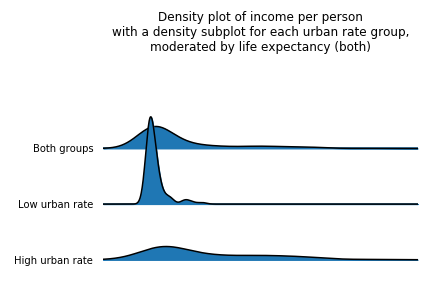

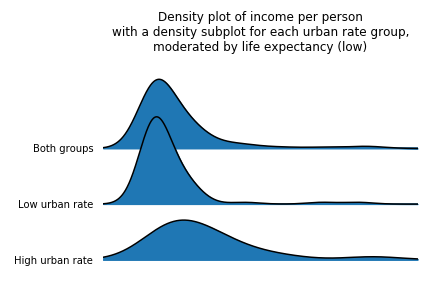

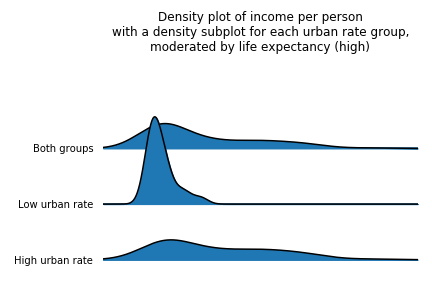

In [28]:
from IPython.core.display import display

column_name_list = anova_moderations_df.sort_values('diff_diff', ascending=False).head(1).values.tolist()[0]
sts = OlsStatements(gapminder_df, number_of_categories=2, ce_column_name=column_name_list[0],
                    qr_column_name=column_name_list[1], md_column_name=column_name_list[2],
                    test_type='ols')
ols_with_moderator(sts, verbose=True)


# Choose three features with a high association and low/high contrast

In [29]:

# Choose three features with a high chi squared contrast
rows_list = []
column_set_list = []
for ce_column_name in number_column_list:
    for cr_column_name in number_column_list:
        for md_column_name in number_column_list:
            moderation_columns_list = [ce_column_name, cr_column_name, md_column_name]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = gapminder_df.dropna(how='any', subset=moderation_columns_list).copy()
                    both_df = create_binned_categories(both_df, 2, md_column_name, 'md')
                    both_df = create_binned_categories(both_df, 5, ce_column_name, 'ce')
                    both_df = create_binned_categories(both_df, 2, cr_column_name, 'cr')
                    
                    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
                    low_df = both_df[match_series].copy()

                    # Get the low cross tab
                    low_crosstab_df = pd.crosstab(low_df['cr_categories'], low_df['ce_categories'])
                    low_crosstab_df = low_crosstab_df.loc[:, (low_crosstab_df != 0).any(axis=0)]

                    if low_crosstab_df.shape[0] > 0:

                        # Get the low statistic
                        low_css = chi2_contingency(low_crosstab_df)[0]

                    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
                    high_df = both_df[match_series].copy()

                    # Get the high cross tab
                    high_crosstab_df = pd.crosstab(high_df['cr_categories'], high_df['ce_categories'])
                    high_crosstab_df = high_crosstab_df.loc[:, (high_crosstab_df != 0).any(axis=0)]

                    if high_crosstab_df.shape[0] > 0:

                        # Get the high statistic
                        high_css = chi2_contingency(high_crosstab_df)[0]
                    
                    row_dict['ce_column_name'] = ce_column_name
                    row_dict['cr_column_name'] = cr_column_name
                    row_dict['md_column_name'] = md_column_name
                    row_dict['css_diff'] = abs(high_css - low_css)
                    rows_list.append(row_dict)
chi_moderations_df = pd.DataFrame(rows_list, columns=['ce_column_name', 'cr_column_name', 'md_column_name', 'css_diff'])
chi_moderations_df.sort_values('css_diff', ascending=False).head(10)

,ce_column_name,cr_column_name,md_column_name,css_diff
207,urban_rate,breast_cancer_per_100th,suicide_per_100th,38.430264
228,urban_rate,life_expectancy,armed_forces_rate,37.414769
392,income_per_person,life_expectancy,armed_forces_rate,34.774718
377,income_per_person,breast_cancer_per_100th,armed_forces_rate,33.173470
447,life_expectancy,internet_use_rate,armed_forces_rate,30.919073
371,income_per_person,breast_cancer_per_100th,suicide_per_100th,30.339864
204,urban_rate,income_per_person,residential_electricity_per_person,28.244197
343,employment_rate,breast_cancer_per_100th,suicide_per_100th,28.017549
396,income_per_person,residential_electricity_per_person,oil_per_person,27.196729
418,breast_cancer_per_100th,residential_electricity_per_person,armed_forces_rate,26.111678


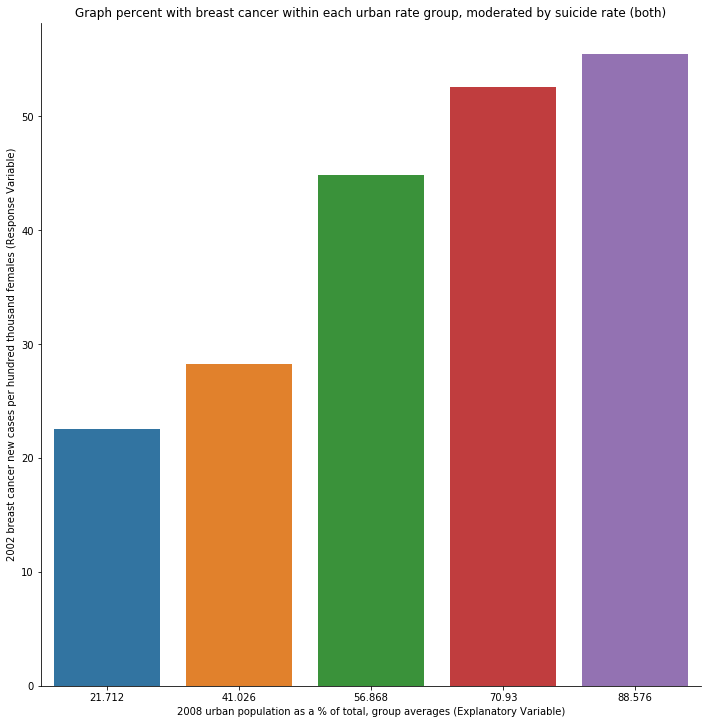

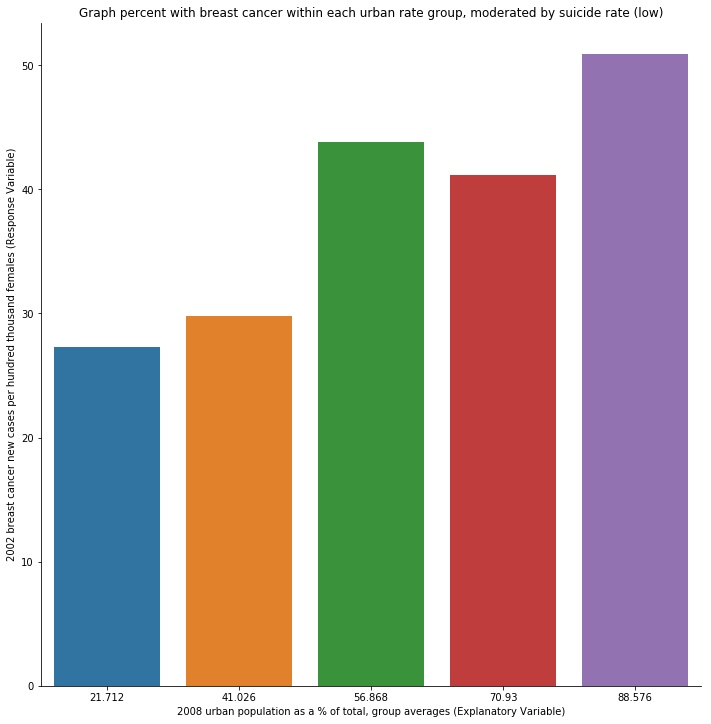

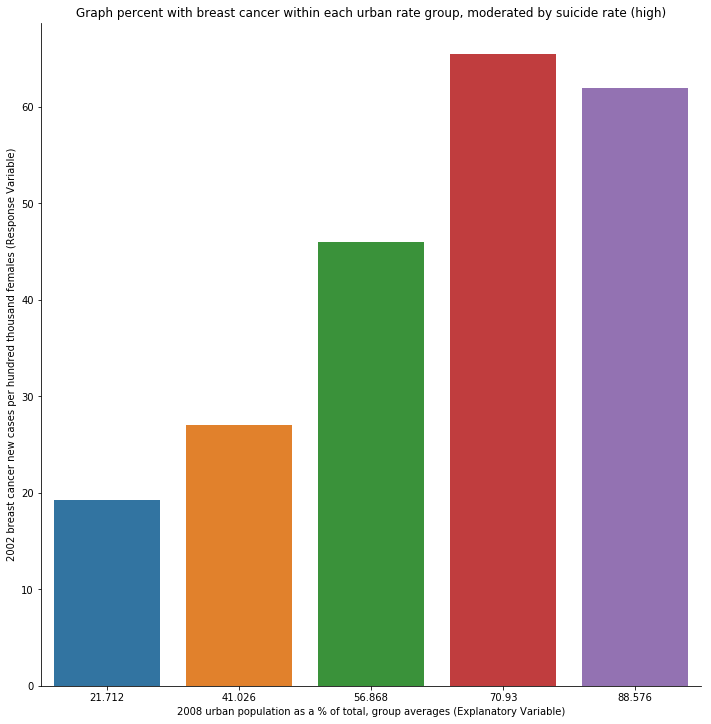

In [30]:

column_name_list = chi_moderations_df.sort_values('css_diff', ascending=False).head(1).values.tolist()[0]
sts = Chi2Statements(gapminder_df, number_of_categories=5, ce_column_name=column_name_list[0],
                     cr_column_name=column_name_list[1], md_column_name=column_name_list[2], test_type='chi2')
chi_square_with_moderator(sts, verbose=True)


# Choose three features with a high r squared and low/high contrast

In [31]:

# Choose three features with a large low/high contrast
rows_list = []
column_set_list = []
for qe_column_name in number_column_list:
    for qr_column_name in number_column_list:
        for md_column_name in number_column_list:
            moderation_columns_list = [qe_column_name, qr_column_name, md_column_name]
            moderation_column_set = set(moderation_columns_list)
            if len(moderation_columns_list) == len(moderation_column_set):
                if moderation_column_set not in column_set_list:
                    column_set_list.append(moderation_column_set)
                    row_dict = {}
                    both_df = create_binned_categories(gapminder_df.dropna(how='any',
                                                                           subset=[qe_column_name,
                                                                                   qr_column_name, md_column_name]).copy(),
                                                       2, md_column_name,'md')
                    match_series = (both_df['md_categories'] == both_df['md_categories'].min())
                    low_df = both_df[match_series].copy()
                    low_cod = pearsonr(low_df[qe_column_name], low_df[qr_column_name])[0]**2

                    match_series = (both_df['md_categories'] == both_df['md_categories'].max())
                    high_df = both_df[match_series].copy()
                    high_cod = pearsonr(high_df[qe_column_name], high_df[qr_column_name])[0]**2
                    
                    row_dict['qe_column_name'] = qe_column_name
                    row_dict['qr_column_name'] = qr_column_name
                    row_dict['md_column_name'] = md_column_name
                    row_dict['cod_diff'] = abs(high_cod - low_cod)
                    rows_list.append(row_dict)
moderations_df = pd.DataFrame(rows_list, columns=['qe_column_name', 'qr_column_name', 'md_column_name', 'cod_diff'])
moderations_df.sort_values('cod_diff', ascending=False).head(10)

,qe_column_name,qr_column_name,md_column_name,cod_diff
282,polity_score,life_expectancy,oil_per_person,0.771913
419,breast_cancer_per_100th,oil_per_person,armed_forces_rate,0.559284
418,breast_cancer_per_100th,residential_electricity_per_person,armed_forces_rate,0.548309
297,female_employment_rate,employment_rate,oil_per_person,0.505718
422,suicide_per_100th,alcohol_consumption,residential_electricity_per_person,0.492300
389,income_per_person,life_expectancy,internet_use_rate,0.472702
416,breast_cancer_per_100th,internet_use_rate,armed_forces_rate,0.429540
112,hiv_rate,polity_score,oil_per_person,0.410567
296,female_employment_rate,employment_rate,residential_electricity_per_person,0.403766
453,internet_use_rate,oil_per_person,armed_forces_rate,0.399988


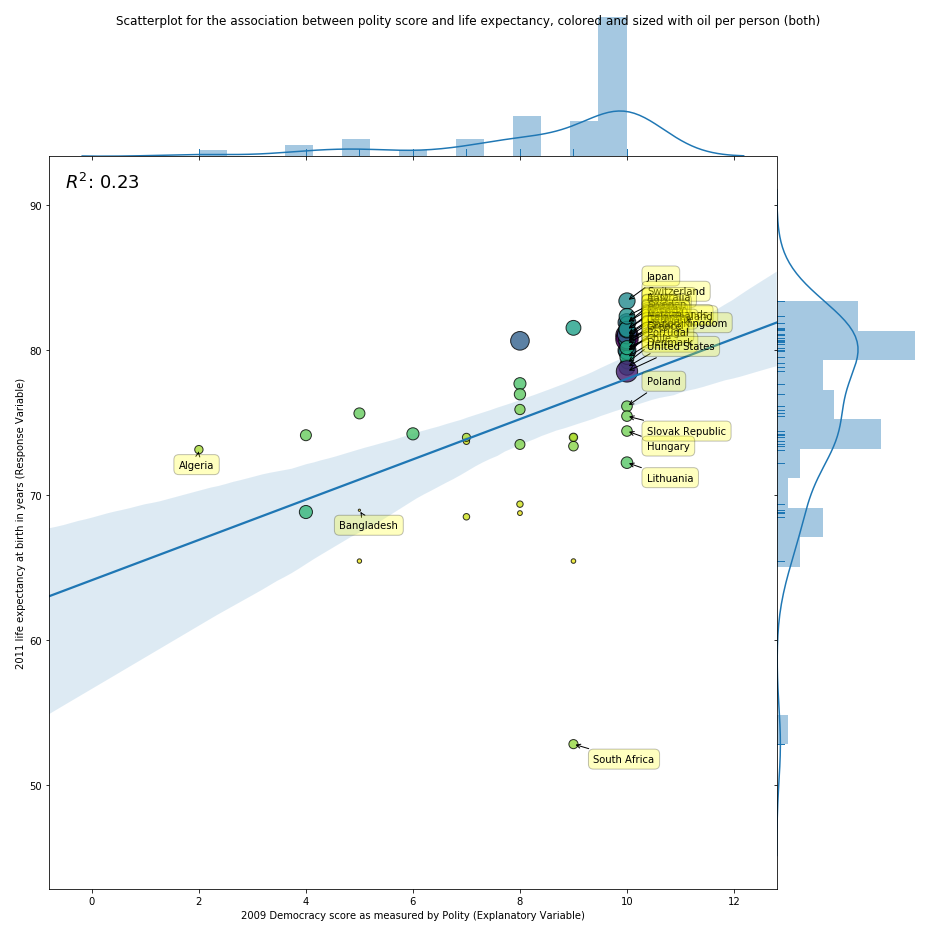

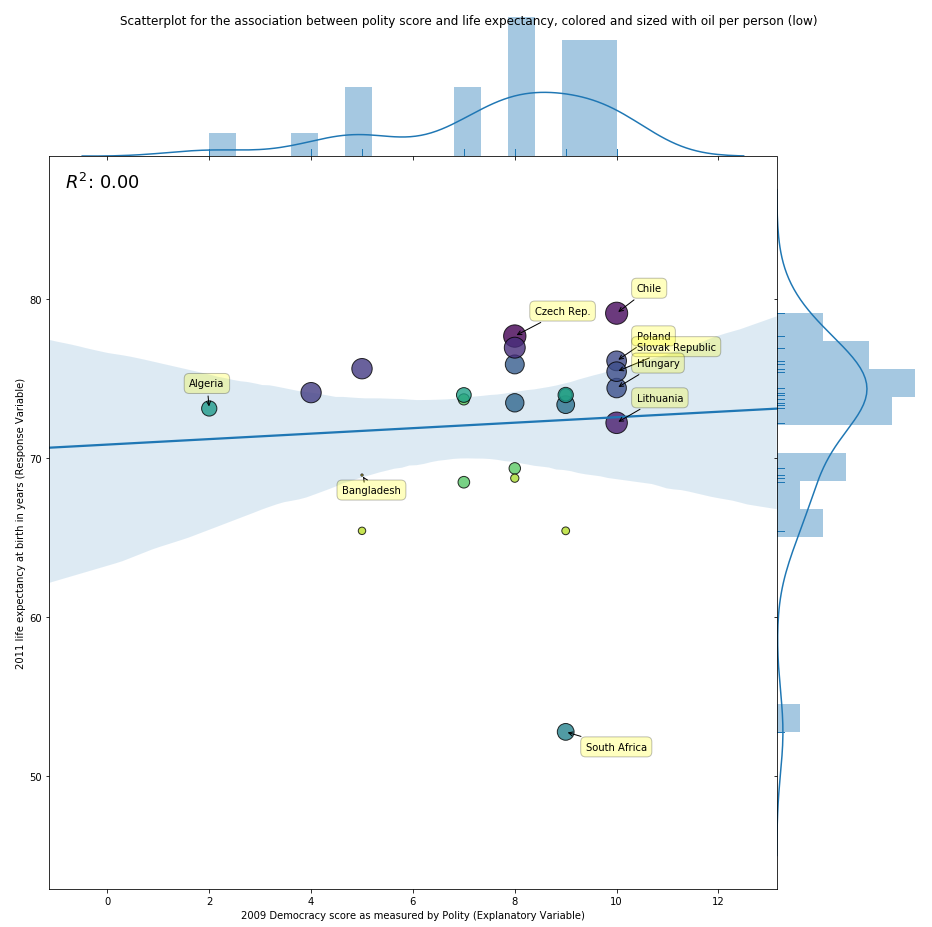

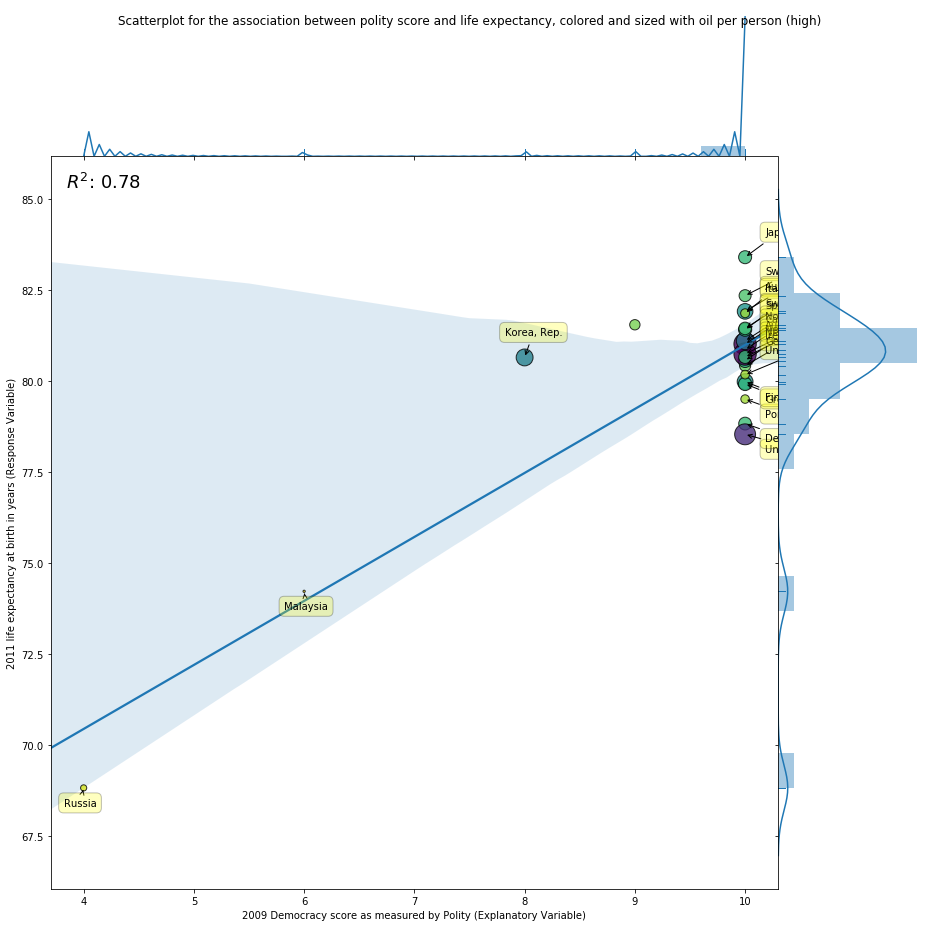

In [32]:

column_name_list = moderations_df.sort_values('cod_diff', ascending=False).head(1).values.tolist()[0]
sts = PearsonrStatements(gapminder_df, qe_column_name=column_name_list[0],
                         qr_column_name=column_name_list[1], md_column_name=column_name_list[2])
pearsons_with_moderator(sts, verbose=True)

In [35]:

%%javascript
var kernel = IPython.notebook.kernel,  
    body = document.body,  
    attribs = body.attributes,  
    command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [36]:
# %load ../../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/' + notebook_path
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')